In [3]:
pip install tensorflow

   ---------------------------------------- 0.0/390.3 MB ? eta -:--:--
   ---------------------------------------- 0.5/390.3 MB 8.2 MB/s eta 0:00:48
   ---------------------------------------- 1.3/390.3 MB 3.4 MB/s eta 0:01:57
   ---------------------------------------- 2.1/390.3 MB 3.2 MB/s eta 0:02:03
   ---------------------------------------- 2.9/390.3 MB 3.4 MB/s eta 0:01:56
   ---------------------------------------- 3.7/390.3 MB 3.5 MB/s eta 0:01:50
   ---------------------------------------- 4.2/390.3 MB 3.1 MB/s eta 0:02:05
    --------------------------------------- 5.0/390.3 MB 3.2 MB/s eta 0:02:02
    --------------------------------------- 5.8/390.3 MB 3.3 MB/s eta 0:01:57
    --------------------------------------- 6.6/390.3 MB 3.3 MB/s eta 0:01:57
    --------------------------------------- 7.6/390.3 MB 3.5 MB/s eta 0:01:51
    --------------------------------------- 8.9/390.3 MB 3.7 MB/s eta 0:01:45
   - -------------------------------------- 10.0/390.3 MB 3.8 MB/s eta 

Enter the stock symbol to predict prices for:  BAC


C:\Users\vdars\AppData\Local\Temp\ipykernel_22720\2199364670.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['interaction'] = filtered_data['sentiment_score'] * filtered_data['mention_count']
C:\Users\vdars\AppData\Local\Temp\ipykernel_22720\2199364670.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['moving_avg_10'] = filtered_data['stock_price'].rolling(window=10).mean()
C:\Users\vdars\AppData\Local\Temp\ipykernel_22720\2199364670.py:30: SettingWithCopyWarning: 
A valu

Mean Absolute Error (MAE): 10.29
Root Mean Squared Error (RMSE): 14.52
R² Score: -0.70


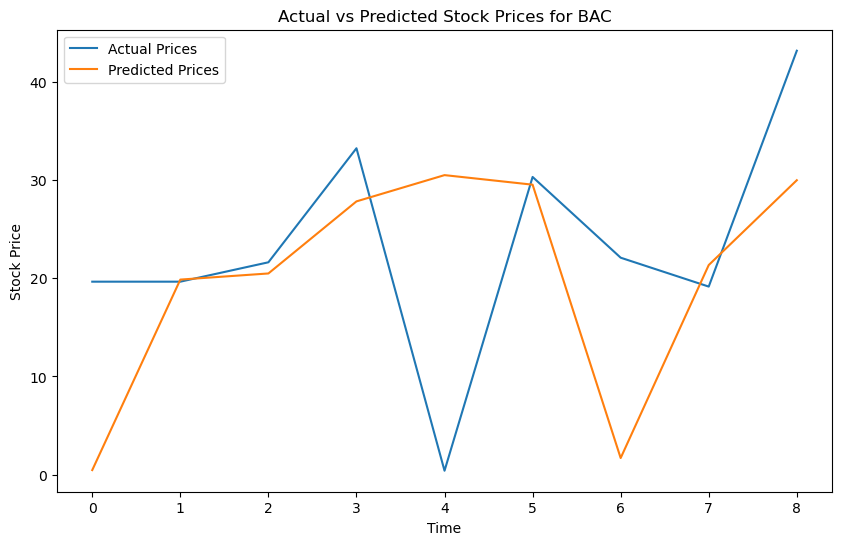

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load and preprocess data
data = pd.read_json('reddit_stock_data_final.json')
data['post_date'] = pd.to_datetime(data['post_date'])
data['year'] = data['post_date'].dt.year
data['month'] = data['post_date'].dt.month
data['day'] = data['post_date'].dt.day
data['hour'] = data['post_date'].dt.hour
data['weekday'] = data['post_date'].dt.weekday
data['price_change'] = pd.to_numeric(data['price_change'], errors='coerce')
data.dropna(subset=['price_change'], inplace=True)

# Get stock symbol input
stock_symbol = input("Enter the stock symbol to predict prices for: ").strip().upper()
filtered_data = data[data['stock_symbol'] == stock_symbol]

if filtered_data.empty:
    print(f"No data available for stock symbol '{stock_symbol}'. Please try another symbol.")
else:
    # Feature engineering
    filtered_data['interaction'] = filtered_data['sentiment_score'] * filtered_data['mention_count']
    filtered_data['moving_avg_10'] = filtered_data['stock_price'].rolling(window=10).mean()
    filtered_data['price_volatility_10'] = filtered_data['stock_price'].rolling(window=10).std()
    filtered_data.dropna(inplace=True)

    # Select features
    features = ['sentiment_score', 'mention_count', 'price_change', 'interaction', 
                'moving_avg_10', 'price_volatility_10', 'year', 'month', 'day', 'hour', 'weekday']
    target = 'stock_price'
    X = filtered_data[features].values
    y = filtered_data[target].values

    # Scale data
    scaler_X = MinMaxScaler(feature_range=(0, 1))
    scaler_y = MinMaxScaler(feature_range=(0, 1))
    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).ravel()

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

    # Gradient Boosting model
    model = GradientBoostingRegressor(random_state=42)

    # Hyperparameter tuning
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='neg_mean_squared_error',
        cv=5,
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    # Predictions
    y_pred_scaled = best_model.predict(X_test)
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
    y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()

    # Metrics
    mae = mean_absolute_error(y_test_original, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))
    r2 = r2_score(y_test_original, y_pred)

    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"R² Score: {r2:.2f}")

    # Plot actual vs predicted
    plt.figure(figsize=(10, 6))
    plt.plot(y_test_original, label='Actual Prices')
    plt.plot(y_pred, label='Predicted Prices')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.title(f'Actual vs Predicted Stock Prices for {stock_symbol}')
    plt.legend()
    plt.show()

    # Predict future stock prices for a specified year
    future_year = int(input("Enter the future year to predict stock prices for: "))

    def generate_synthetic_data(future_year, num_samples=100):
        np.random.seed(42)
        synthetic_data = []
        for _ in range(num_samples):
            sentiment_score_variation = np.random.uniform(-0.3, 0.3)
            mention_count_variation = np.random.randint(-50, 50)
            price_change_variation = np.random.uniform(-0.1, 0.1)
            BASE_YEAR = filtered_data['year'].max()
            trend_factor = (future_year - BASE_YEAR) * 0.05

            synthetic_data.append({
                'sentiment_score': np.mean(filtered_data['sentiment_score']) + sentiment_score_variation + trend_factor,
                'mention_count': np.mean(filtered_data['mention_count']) + mention_count_variation,
                'price_change': np.mean(filtered_data['price_change']) + price_change_variation,
                'interaction': (np.mean(filtered_data['sentiment_score']) + sentiment_score_variation) *
                               (np.mean(filtered_data['mention_count']) + mention_count_variation),
                'moving_avg_10': np.mean(filtered_data['moving_avg_10']),
                'price_volatility_10': np.mean(filtered_data['price_volatility_10']),
                'year': future_year,
                'month': np.random.randint(1, 13),
                'day': np.random.randint(1, 29),
                'hour': np.random.randint(0, 24),
                'weekday': np.random.randint(0, 7)
            })
        return pd.DataFrame(synthetic_data)

    synthetic_df = generate_synthetic_data(future_year)
    synthetic_scaled = scaler_X.transform(synthetic_df)
    future_predictions_scaled = best_model.predict(synthetic_scaled)
    future_predictions = scaler_y.inverse_transform(future_predictions_scaled.reshape(-1, 1)).ravel()

    average_future_price = np.mean(future_predictions)
    print(f"Predicted average stock price for {stock_symbol} in the year {future_year}: {average_future_price:.2f}")
